# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [91]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format)

##### Put your markdown formulas here

$$\nabla_w L(w,w_0)= -\frac{1}{N} \sum_i^N \frac{y_i x_i \cdot exp(-y_i (w^Tx_i+w_0))}{1+exp(-y_i (w^Tx_i+w_0))} + \gamma \dfrac{w_k}{| w_k |}+ 2 \cdot \beta \cdot w $$

$$\nabla_{w_0} L(w,w_0)= -\frac{1}{N} \sum_i^N \frac{y_i exp(-y_i (w^Tx_i+w_0))}{1+exp(-y_i (w^Tx_i+w_0))} $$

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [92]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    return (1 / len(X)) * np.sum(1 + np.exp(-y * (np.dot(X, np.transpose(w)) + w0))) + gamma * np.linalg.norm(w,
                                                                                                              1) + beta * np.linalg.norm(
        w ** 2, 2)


#### 3. [0.25 points] Implement the gradient (as a function)

In [93]:
def get_grad_w0(X, w, w0, y):
    return 1 / len(X) * np.sum(y * (1 / (1 + np.exp(-y * (np.dot(X, w) + w0))) - 1))


def get_grad_w(X, beta, gamma, w, w0, y):
    return 1 / len(X) * np.dot(y * (1 / (1 + np.exp(-y * (np.dot(X, w) + w0))) - 1), X) + gamma * np.sign(
        w) + 2 * beta * w


def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    grad_w0 = get_grad_w0(X, w, w0, y)
    grad_w = get_grad_w(X, beta, gamma, w, w0, y)

    return grad_w, grad_w0

#### Check yourself

In [94]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert (np.allclose(grad_w,
                    [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                    rtol=1e-2) & np.allclose(grad_w0,
                                             -0.2078231418067844,
                                             rtol=1e-2)
        )

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [95]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [96]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=0.0001, max_iter=1000, random_state=116):
        # self.learning_rate = 1e-3
        # self.tolerance = 0.01
        self.beta = beta
        self.gamma = gamma
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.learning_rate = lr
        self.random_state = random_state
        self.l_history = list()
        # you may be additional properties if you wish

    def fit(self, X, y):
        np.random.seed(self.random_state)
        self.w = np.random.normal(size=X.shape[1])
        self.w0 = np.random.normal(size=1)
        for i in range(self.max_iter):
            self.loop_action(X, y)
            if self.toler_norm() < self.tolerance:
                break

        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps

        # your code here

        return self

    def toler_norm(self):
        return np.linalg.norm(-self.learning_rate * grad_w)

    def loop_action(self, X, y):
        grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
        self.w = self.w - self.learning_rate * grad_w
        self.w0 = self.w0 - self.learning_rate * grad_w0
        self.l_history.append(loss(X, y, self.w, self.w0, self.gamma, self.beta))

    def predict(self, X):
        # return vector of predicted labels for each object from X
        # your code here
        default_threshold = 0.5
        predict_x, predict_y = self.predict_proba(X)
        predict_x[predict_x <= default_threshold] = -1
        predict_x[predict_x > default_threshold] = 1
        predict = predict_x
        return predict

    def predict_proba(self, X):
        return np.array([1 / (1 + np.exp(np.dot(X, self.w) + self.w0)), 1 / (1 + np.exp(-np.dot(X, self.w) - self.w0))])

In [97]:
# sample data to test your model
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                           random_state=42, n_clusters_per_class=1)

In [98]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:, 0], X[:, 1], c=y)

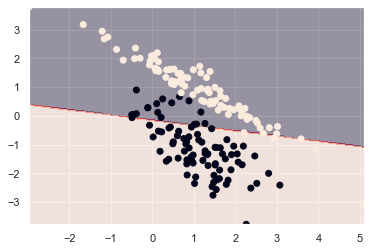

In [99]:
model = Logit(0, 0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

Если не менять данные при инициализации, то увидеть что-то тут не получиться, поэтому инициализация была изменена в lr и tolerance.

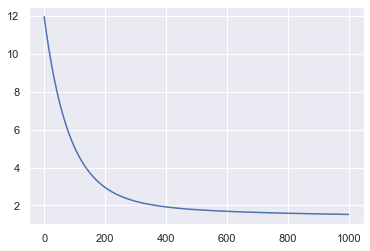

In [100]:
# your code here
plt.plot(model.l_history);

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [101]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import pandas as pd

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
kernels = ['linear', 'poly', 'rbf']


def appending_lists():
    for i in range(2):
        linear_list.append([])
    for i in range(2):
        polynomial_list.append([])
    for i in range(2):
        rbf_list.append([])


linear_list = [[]]
polynomial_list = [[]]
rbf_list = [[]]

appending_lists()

In [102]:
def kernel_model_actions():
    global kernel_predicted
    kernel_model = SVC(kernel=kernel, C=hyperparam)
    kernel_model.fit(x_train, y_train)
    kernel_predicted = kernel_model.predict(x_test)

In [103]:
def linear_list_func():
    linear_list[0].append(accuracy_score(y_test, kernel_predicted))
    linear_list[1].append(roc_auc_score(y_test, kernel_predicted))
    linear_list[2].append(f1_score(y_test, kernel_predicted))


def poly_list_func():
    polynomial_list[0].append(accuracy_score(y_test, kernel_predicted))
    polynomial_list[1].append(roc_auc_score(y_test, kernel_predicted))
    polynomial_list[2].append(f1_score(y_test, kernel_predicted))


def rbf_list_func():
    rbf_list[0].append(accuracy_score(y_test, kernel_predicted))
    rbf_list[1].append(roc_auc_score(y_test, kernel_predicted))
    rbf_list[2].append(f1_score(y_test, kernel_predicted))


In [104]:
for hyperparam in np.arange(0.001, 5, 0.1):
    for kernel in kernels:
        kernel_model_actions()
        if kernel == kernels[0]:
            linear_list_func()
        if kernel == kernels[1]:
            poly_list_func()
        if kernel == kernels[2]:
            rbf_list_func()

In [105]:
def tmp_plotting():
    plt.ylim(0.95, 1.03)
    plt.xlim(0, 10)
    plt.legend()
    plt.show()


def plotting_accuracy():
    plt.plot(pd.Series(linear_list[0]), label=kernels[0], color='orange')
    plt.plot(pd.Series(polynomial_list[0]), label=kernels[1], color='red')
    plt.plot(pd.Series(rbf_list[0]), label=kernels[2], color='green')
    tmp_plotting()


def plotting_auc_score():
    plt.plot(linear_list[1], label=kernels[0], color='orange')
    plt.plot(polynomial_list[1], label=kernels[1], color='red')
    plt.plot(rbf_list[1], label=kernels[2], color='green')
    tmp_plotting()


def plotting_f1_score():
    plt.plot(linear_list[2], label=kernels[0], color='orange')
    plt.plot(polynomial_list[2], label=kernels[1], color='red')
    plt.plot(rbf_list[2], label=kernels[2], color='green')
    tmp_plotting()

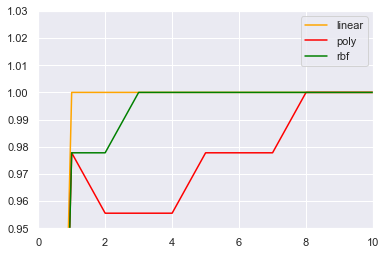

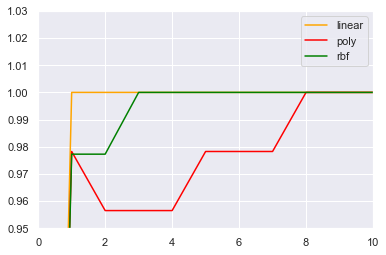

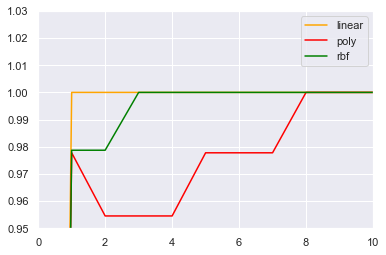

In [106]:
# pd.Series(linear_list[0]).value_counts().plot(kind='bar')
# data = pd.DataFrame([], columns=['tmp', 'linear'])
# data['tmp'] = np.arange(0.001, 5, 0.1)
# data['linear'] = linear_list[0]
# display(data)
# data.plot(x=data['tmp'], y=data['linear'], kind='scatter')
plotting_accuracy()
plotting_auc_score()
plotting_f1_score()

## PART 3: Natural Language Processing

#### 7. [1.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively

    sample data may look like:

    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>
    </table>
</center>

2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [107]:
# your code here

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


In [108]:
# your code here

#### 9. [1 point] Analysing ROC AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate. Pay attention to `thresholds` parameter in sklearn roc_curve

In [109]:
# your code here

### Multiclass logit

#### 10. [1 point] Take the One-VS-One classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html">OneVsOneClassifier</a>

* use the data you got at the previous step for 6 authors
* divide the data into train and test samples with 0.7 split rate
* using GridSearchCV - find the best parameters for the models (by F1 score)
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)

In [110]:
# your code here